# Construindo um Classificador de Textos
Uma das aplicações mais comuns em mineração de textos é a classificações de documentos em categorias pré-definidas, sejam elas autorais, temáticas, temporais ou outras. 

Neste capítulo iremos explorar os passos necessários para o desenvolvimento de um classificador de documentos utilizando as análises feitas sobre o corpus do DHBB nos capítulos anteriores.

Para esta tarefa utilizaremos modelos de machine learning clássicos disponibilizados na biblioteca [Scikit-Learn](https://scikit-learn.org/). Começaremos então importando algumas funcionalidades a partir do Scikit-Learn. Os demais imports já foram utilizados anteriormente.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec, word2vec
import spacy
from spacy import displacy
from string import punctuation
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import os

## Preparando o corpus
Vamos utilizar o corpus do DHBB conforme armazenado na biblioteca SQLite anteriormente. Abaixo iremos desenvolver um iterador sobre o corpus que fará um preprocessamento básico dos documentos.

In [3]:
eng = create_engine("sqlite:///minha_tabela.sqlite")
nlp = spacy.load("pt_core_news_sm")
class DHBBCorpus:
    def __init__(self, ndocs=10000, process=True):
        self.process = process
        self.ndocs = min(7838,ndocs)
        self.counter = 1
    def __iter__(self):
        with eng.connect() as con:
            res = con.execute(f'select corpo from resultados limit {self.ndocs};')
            for doc in res:
                if self.process:
                    d = self.pre_process(doc[0])
                else: 
                    d = doc[0]
                if self.counter%10 == 0:
                    print (f"Verbete {self.counter} de {self.ndocs}\r", end='')
                
                yield d
                self.counter += 1
    def pre_process(self, doc):
        n = nlp(doc, disable=['tagger', 'ner','entity-linker', 'textcat','entity-ruler','merge-noun-chunks','merge-entities','merge-subtokens'])
        results = [token.text.strip().strip(punctuation) for token in n if not token.is_stop]
        return results

## Carregando o Modelo Word2vec
Vamos utilizar a representação vetorial do corpus construida anteriormente como base para o treinamento do classificador. 

In [4]:
model = Word2Vec.load('dhbb.w2v')

In [5]:
model.wv.vectors.shape

(38762, 100)

Como  o word2vec é uma representação vetorial do vocabulário do corpus, e desejamos treinar um modelo para classificar documentos, precisamos primeiro construir uma representação dos documentos do corpus no mesmo espaço vetorial gerado pelo Word2vec.

Na função abaixo, contruimos um vetor de documento que é a média dos vetores das palavras únicas que este contém.

In [6]:
def build_document_vector(text):
    """
    Build a scaled vector for the document (mean of the words present in it)
    :param text: document to be vectorized (tokenized)
    :param model: word2vec model
    :return:
    """
    feature_count = model.wv.vectors.shape[1]
    vec = np.zeros(feature_count).reshape((1, feature_count))
    count = 0.
    

    for word in text:
        try:
            vec += model.wv[word].reshape((1, feature_count))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [7]:

def gera_docv(n):
    corpus = DHBBCorpus(n)
    for doc in corpus:
        v = build_document_vector(set(doc))
        yield v


## Preparando os dados treinamento do Classificador
Abaixo vamos calcular os vetores dos documentos no espaço definido pelo W2V. Como este é um processo longo vamos salvar o resultado, para não ter que re-gerar os vetores de documento das próximas vezes.

In [8]:
if os.path.exists('doc_feature_matrix.csv.gz'):
    data = pd.read_csv('doc_feature_matrix.csv.gz')
else:
    gerador = gera_docv(10000)
    data = pd.DataFrame(data=np.vstack([a for a in gerador]), columns=range(100))
    data.to_csv('doc_feature_matrix.csv.gz')
data

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,0.251411,-0.092618,-0.367610,0.156986,-0.339056,-0.080486,0.192228,-0.230927,-0.129720,...,-0.354930,0.257672,-0.182260,-0.072084,0.155995,0.025738,-0.186744,-0.309680,0.003222,0.116559
1,1,-0.444796,-0.107734,-0.371062,0.248178,-0.342896,0.180991,0.622804,0.390060,-0.197826,...,0.162281,-0.923582,-0.449693,-0.194215,0.884861,0.355686,0.418442,-0.504399,-1.110405,0.292351
2,2,-0.186797,-0.099321,-0.489939,0.603691,-0.220742,0.163514,0.201998,-0.068645,-0.170712,...,0.309139,-0.249686,-0.252961,-0.000214,0.428697,0.477869,0.114001,-0.259199,-0.860501,0.281628
3,3,-0.015474,-0.331179,-0.188871,0.071852,-0.118083,0.273842,0.244981,-0.070634,-0.275265,...,0.048260,0.186905,-0.201033,-0.294315,-0.119009,0.070466,-0.013867,-0.257075,-0.069757,0.215312
4,4,-0.069459,0.000653,-0.267939,0.539355,-0.167328,-0.028850,0.572703,0.225255,-0.364476,...,0.073481,-0.567660,-0.298699,-0.237357,0.528733,0.298273,0.037333,-0.491313,-0.742250,0.370616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7833,7833,-0.069599,0.153431,-0.571671,0.378038,-0.248409,-0.060014,0.452256,0.176986,-0.235890,...,-0.191336,-0.586688,-0.180140,-0.130464,0.625573,0.382755,0.069184,-0.546153,-0.663578,0.326829
7834,7834,-0.170249,-0.081334,-0.492545,0.443016,-0.041892,0.183765,0.371429,0.106385,-0.080806,...,0.225322,-0.254757,-0.258577,0.014742,0.309729,0.376458,0.032279,-0.256777,-0.743823,0.226570
7835,7835,-0.382044,-0.422822,-0.587220,0.320492,-0.226514,0.172044,0.616719,-0.043985,-0.258257,...,-0.005524,-0.341694,-0.393351,-0.104909,0.011569,0.355231,0.376438,-0.383147,-0.443361,0.176735
7836,7836,0.226604,-0.230992,-0.294525,-0.005927,-0.293173,0.076686,0.057251,-0.154211,-0.186203,...,-0.148946,0.358122,-0.054703,-0.052285,0.038732,0.011719,-0.135485,-0.256960,0.012294,0.020287


### Definindo a categoria de cada documento para o treinamento
Nosso objetvo será diferenciar entre verbetes *temáticos* e *biográficos*.

In [9]:
def gera_alvo():
    df = pd.read_sql_query('select natureza from resultados', con=eng)
    alvo = df.natureza.values=='biográfico'
    return alvo
Y = gera_alvo()
print(f"Número de verbetes temáticos: {len(Y)-sum(Y)}")

Número de verbetes temáticos: 973


In [10]:
df = pd.read_sql_query('select * from resultados', con=eng)

In [11]:
df.natureza.value_counts()

natureza
biográfico    6865
temático       973
Name: count, dtype: int64

Vamos dividir a tabela de vetores de documentos em Biográficos e temáticos

In [12]:
biog = data.iloc[Y]
tem = data.iloc[~Y]

Como o número de verbetes biográficos é muito maior, vamos tomar iguais numeros de cada tipo para equilibrar o nosso conjunto de treinamento de documentos.

In [29]:
data2 = pd.concat([biog[:963],tem],axis=0)
Y2 = np.array([True]*963 + [False]*len(tem))
data2

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,0.251411,-0.092618,-0.367610,0.156986,-0.339056,-0.080486,0.192228,-0.230927,-0.129720,...,-0.354930,0.257672,-0.182260,-0.072084,0.155995,0.025738,-0.186744,-0.309680,0.003222,0.116559
1,1,-0.444796,-0.107734,-0.371062,0.248178,-0.342896,0.180991,0.622804,0.390060,-0.197826,...,0.162281,-0.923582,-0.449693,-0.194215,0.884861,0.355686,0.418442,-0.504399,-1.110405,0.292351
2,2,-0.186797,-0.099321,-0.489939,0.603691,-0.220742,0.163514,0.201998,-0.068645,-0.170712,...,0.309139,-0.249686,-0.252961,-0.000214,0.428697,0.477869,0.114001,-0.259199,-0.860501,0.281628
3,3,-0.015474,-0.331179,-0.188871,0.071852,-0.118083,0.273842,0.244981,-0.070634,-0.275265,...,0.048260,0.186905,-0.201033,-0.294315,-0.119009,0.070466,-0.013867,-0.257075,-0.069757,0.215312
5,5,-0.006569,0.070158,-0.556755,0.210324,-0.502553,0.172335,0.327112,0.091819,-0.085008,...,-0.014528,-0.428668,-0.278508,-0.156567,0.553669,0.141698,-0.004496,-0.401562,-0.514297,0.100853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7777,7777,-0.198130,0.248924,-0.391260,0.590541,0.014977,0.136703,0.092994,0.224973,-0.408088,...,0.246091,-0.581098,-0.312761,-0.034015,0.733376,0.460601,0.386440,-0.451271,-1.092295,0.235936
7789,7789,-0.526813,-0.189568,-0.614463,0.543363,-0.153835,0.249338,0.536001,0.091591,-0.083802,...,0.000970,-0.115585,-0.267506,-0.000516,-0.292849,0.098837,-0.041638,-0.100240,-0.336108,0.313756
7807,7807,-0.165131,0.094592,-0.568769,0.634284,-0.098892,0.067542,0.166902,0.170849,-0.234814,...,0.101010,-0.432262,-0.166351,-0.099340,0.479865,0.669177,0.193949,-0.248294,-0.799425,0.576188
7810,7810,-0.123791,-0.083936,-0.556963,0.379353,-0.414466,0.012076,0.205557,-0.324124,-0.108826,...,-0.144140,0.202595,-0.318131,-0.016879,0.310178,0.209647,0.001082,-0.242404,-0.379883,0.214805


In [20]:
from matplotlib import pyplot as plt
%matplotlib inline
def print_class_report(Xtest, Ytest, clf, clf_name):
    """
    Imprime relatório de classificação
    :param Xtest:
    :param Ytest:
    :param clf: classificador trainado
    :param clf_name: nome do classificador
    """
    y_predict = clf.predict(Xtest)
    print('\nRelatório de classificação para {}:\n'.format(clf_name))
    print(classification_report(Ytest, y_predict, target_names=['Temático', 'Biográfico']))
    

def plot_roc(probas):
    tprs = []
    fprs = []


    labels = ['False positive rate', 'True Positive rate']
    for k, v in probas.items():
        roc_aucs = []
        for j, fold in enumerate(v):
            try:
                fpr, tpr, thresholds = roc_curve(fold[1], fold[0][:, 1])
            except IndexError:
                print(fold[0], fold[0].shape)
                continue
            roc_aucs.append(auc(fpr, tpr))
            tprs.append([float(t) for t in tpr])
            fprs.append([float(f) for f in fpr])

        print('{}: AUCs: {}'.format(k, str(roc_aucs)))
    plt.scatter(fprs, tprs, [], "Curva ROC ", "points", 0, 0)
    

## Definindo os modelos
Vamos comparar a performance de 3 modelos. Dois tipos de modelos de "ensemble", *Random forest* e *Extra Trees* e um terceiro baseado na segmentação do espaço vetorial, o SVC.

In [21]:
rfclf = make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators=400, criterion='entropy', n_jobs=-1, min_samples_leaf=3, warm_start=True, verbose=0))
etclf = make_pipeline(StandardScaler(),ExtraTreesClassifier(n_estimators=400, n_jobs=-1,min_samples_leaf=3, warm_start=True, verbose=0))
svcclf = make_pipeline(StandardScaler(),SVC(probability=True))

Adicionalmente iremos usar um Classificador por votos que procurará combinar o melhor dos três modelos acima em uma classificação por votação.

In [22]:
vcclf = VotingClassifier(estimators=[('rf', rfclf), ('et', etclf),('svc', svcclf)], 
                         voting='soft', weights=[1,1,1])

## Treinando e validando o classificador

Os modelos serão treinados usando um esquema de validação cruzada de cinco rodadas com randomização.

In [24]:
from collections import defaultdict
from sklearn.metrics import RocCurveDisplay

acc_hist = defaultdict(lambda: [])
X2 = data2.values

Xtrain,Xtest,Ytrain,Ytest = train_test_split(X2,Y2, test_size=.25)

skf = StratifiedKFold(5, shuffle=True)

for train_index, test_index in skf.split(Xtrain, Ytrain):
    Xtr = Xtrain[train_index]
    Ytr = Ytrain[train_index]
    Xval = Xtrain[test_index]
    Yval = Ytrain[test_index]
    print("==> Fitting:")
    # print("Extra Trees")
    etclf.fit(Xtr,Ytrain[train_index])
    # print("Random Forest")
    rfclf.fit(Xtr, Ytrain[train_index])
    # print("SVC")
    svcclf.fit(Xtr, Ytrain[train_index])
    # print("Voting")
    vcclf.fit(Xtr, Ytrain[train_index])
    print("==> Scoring:")
    acc_hist['ET'].append(cross_val_score(etclf, Xtrain, Ytrain, cv=2, n_jobs=-1).mean())
    acc_hist['RF'].append(cross_val_score(rfclf, Xtrain, Ytrain, cv=2, n_jobs=-1).mean())
    acc_hist['SVC'].append(cross_val_score(svcclf, Xtrain, Ytrain, cv=2, n_jobs=-1).mean())
    acc_hist['Voting'].append(vcclf.score(Xtrain, Ytrain))
print_class_report(Xtest, Ytest, etclf, 'ET')
print_class_report(Xtest, Ytest, rfclf, 'RF')
print_class_report(Xtest, Ytest, svcclf, 'SVC')
print_class_report(Xtest, Ytest, vcclf, 'Voting')

==> Fitting:
==> Scoring:
==> Fitting:
==> Scoring:
==> Fitting:
==> Scoring:
==> Fitting:
==> Scoring:
==> Fitting:
==> Scoring:

Relatório de classificação para ET:

              precision    recall  f1-score   support

    Temático       0.97      0.76      0.85       241
  Biográfico       0.80      0.98      0.88       243

    accuracy                           0.87       484
   macro avg       0.89      0.87      0.87       484
weighted avg       0.89      0.87      0.87       484


Relatório de classificação para RF:
              precision    recall  f1-score   support

    Temático       0.99      0.84      0.91       241
  Biográfico       0.86      0.99      0.92       243

    accuracy                           0.92       484
   macro avg       0.93      0.92      0.92       484
weighted avg       0.93      0.92      0.92       484


Relatório de classificação para SVC:

              precision    recall  f1-score   support

    Temático       0.94      0.70      0.80    

### Curva ROC para os classificadores
A curva ROC nos informa o quanto podemos maximizar a taxa de verdadeiros positivos(classificações corretas), ao mesmo tempo em que minimizamos a taxa de falsos positivos (classificações erradas), apenas escolhendo a probabilidade de corte para pertinência à classe 1. O melhor modelo é o que mais se aproxima do canto superior esquerdo da figura (maximizando a área sob a curva), neste caso o modelo *Random Forest*.

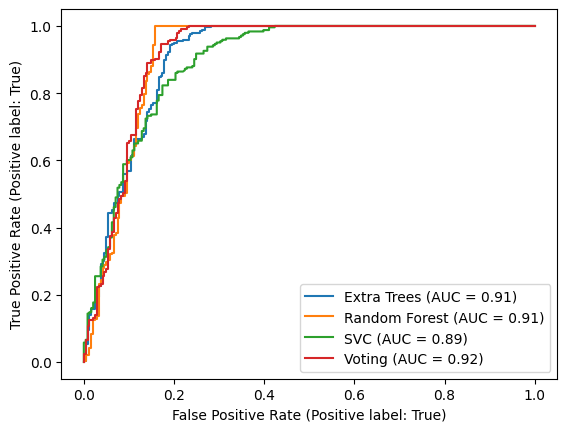

In [25]:
#  ROC curve for each model

et_roc = RocCurveDisplay.from_estimator(etclf, Xtest, Ytest, name='Extra Trees')
ax = plt.gca()
rf_roc = RocCurveDisplay.from_estimator(rfclf, Xtest, Ytest, ax=ax, name='Random Forest')
svc_roc = RocCurveDisplay.from_estimator(svcclf, Xtest, Ytest, ax=ax, name='SVC')
vc_roc = RocCurveDisplay.from_estimator(vcclf, Xtest, Ytest, ax=ax, name='Voting')

# print('trained {} documents.'.format((n+1)*batchsize))
df_acc = pd.DataFrame(acc_hist)

### Acurácia
Se olharmos para a acurácia, vemos que esta não melhora com as 5 rodadas de validação cruzada, indicando que podemos reduzí-las ou mesmo eliminar completamente a validação cruzada.

In [26]:
df_acc

,ET,RF,SVC,Voting
0,0.867080,0.930441,0.800964,0.961433
1,0.853994,0.929752,0.800964,0.949036
2,0.860193,0.926309,0.800964,0.961433
3,0.864325,0.928375,0.800964,0.964187
4,0.869835,0.927686,0.800964,0.956612


### Precisão e Revocação
Outra métrica para comparação dos modelos são suas curvas de Precisão-revocação, que apresentam os trade-offs possíveis entre estas duas medidas como função do limiar de decisão para cada classe. Nesta análise o modelo cuja curva mais se aproxima do canto superior direito da figura é o melhor, neste caso novamente o modelo *Random Forest* se destaca.

In [27]:
from sklearn.metrics import PrecisionRecallDisplay

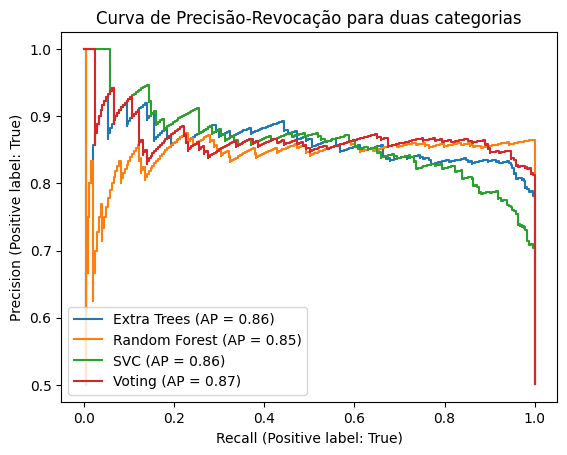

In [28]:
display = PrecisionRecallDisplay.from_estimator(
    etclf, Xtest, Ytest, name="Extra Trees"
)
ax = plt.gca()
PrecisionRecallDisplay.from_estimator(
    rfclf, Xtest, Ytest, name="Random Forest", ax=ax
)
PrecisionRecallDisplay.from_estimator(
    svcclf, Xtest, Ytest, name="SVC", ax=ax
)
PrecisionRecallDisplay.from_estimator(
    vcclf, Xtest, Ytest, name="Voting", ax=ax
)
_ = display.ax_.set_title("Curva de Precisão-Revocação para duas categorias")